# Predict MVP 2022 TEST


In [2]:
import pickle
import pandas as pd
import numpy as np
from nba_api.stats.endpoints import commonallplayers #per avere l'elenco dei giocatori (id)
from nba_api.stats.endpoints import playercareerstats #per avere i dati
from nba_api.stats.endpoints import playerawards #per sapere chi ha vinto MVP
from nba_api.stats.endpoints import teamyearbyyearstats #classifiche finali delle squadre
import pandas as pd
from tqdm import tqdm
import pickle

## Scarico i giocatori 2022

In [3]:
from_year = 2021

total_players = commonallplayers.CommonAllPlayers().get_data_frames()[0]
total_players['TO_YEAR'] = total_players['TO_YEAR'].astype('int')
total_players = total_players[total_players['TO_YEAR'] == from_year]

#Ho controllato che in total_players, il PERSON_ID sia univoco
total_players

,PERSON_ID,DISPLAY_LAST_COMMA_FIRST,DISPLAY_FIRST_LAST,ROSTERSTATUS,FROM_YEAR,TO_YEAR,PLAYERCODE,PLAYER_SLUG,TEAM_ID,TEAM_CITY,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CODE,TEAM_SLUG,GAMES_PLAYED_FLAG,OTHERLEAGUE_EXPERIENCE_CH
10,1630173,"Achiuwa, Precious",Precious Achiuwa,1,2020,2021,precious_achiuwa,precious_achiuwa,1610612761,Toronto,Raptors,TOR,raptors,raptors,Y,00
22,203500,"Adams, Steven",Steven Adams,1,2013,2021,steven_adams,steven_adams,1610612763,Memphis,Grizzlies,MEM,grizzlies,grizzlies,Y,00
24,1628389,"Adebayo, Bam",Bam Adebayo,1,2017,2021,bam_adebayo,bam_adebayo,1610612748,Miami,Heat,MIA,heat,heat,Y,00
40,1630583,"Aldama, Santi",Santi Aldama,1,2021,2021,santi_aldama,santi_aldama,1610612763,Memphis,Grizzlies,MEM,grizzlies,grizzlies,Y,00
43,200746,"Aldridge, LaMarcus",LaMarcus Aldridge,1,2006,2021,lamarcus_aldridge,lamarcus_aldridge,1610612751,Brooklyn,Nets,BKN,nets,nets,Y,00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4701,201152,"Young, Thaddeus",Thaddeus Young,1,2007,2021,thaddeus_young,thaddeus_young,1610612759,San Antonio,Spurs,SAS,spurs,spurs,Y,00
4703,1629027,"Young, Trae",Trae Young,1,2018,2021,trae_young,trae_young,1610612737,Atlanta,Hawks,ATL,hawks,hawks,Y,00
4704,1630209,"Yurtseven, Omer",Omer Yurtseven,1,2020,2021,tmp_omer_yurtseven,omer_yurtseven,1610612748,Miami,Heat,MIA,heat,heat,Y,01
4707,203469,"Zeller, Cody",Cody Zeller,1,2013,2021,cody_zeller,cody_zeller,1610612757,Portland,Trail Blazers,POR,blazers,blazers,Y,00


In [7]:
all_teams_history = list(total_players["TEAM_ID"].drop_duplicates())
data_all_team_stats = pd.DataFrame()

for team in all_teams_history:
    t = teamyearbyyearstats.TeamYearByYearStats(team_id=team).get_data_frames()[0]
    #t["SEASON_ID"] = t[t["SEASON_ID"] == "2021-22"] # Non cambia tanto perchè nel get prende tutti
    data_all_team_stats = pd.concat([data_all_team_stats, t], axis=0, ignore_index=True)

data_all_team_stats = data_all_team_stats.rename(columns={"YEAR": "SEASON_ID"})
data_all_team_stats = data_all_team_stats[["TEAM_ID", "SEASON_ID", "CONF_RANK"]]

with open("data_all_team_stats_2022.pkl",'wb') as f:
    pickle.dump(data_all_team_stats,f)

data_all_team_stats

,TEAM_ID,SEASON_ID,CONF_RANK
0,1610612761,1995-96,14
1,1610612761,1996-97,12
2,1610612761,1997-98,15
3,1610612761,1998-99,10
4,1610612761,1999-00,6
...,...,...,...
1562,1610612742,2017-18,13
1563,1610612742,2018-19,14
1564,1610612742,2019-20,7
1565,1610612742,2020-21,5


In [8]:
total_names = total_players[["PERSON_ID", "DISPLAY_FIRST_LAST"]]
total_stats = pd.DataFrame()
with open("data_all_team_stats_2022.pkl", "rb") as f:
    data_all_team_stats = pickle.load(f)

for index, row in tqdm(total_names.iterrows()):
    stats = playercareerstats.PlayerCareerStats(player_id=row["PERSON_ID"]).get_data_frames()[0]

    stats = stats.drop(stats.columns[[2, 4, 7]], axis=1)

    awards = playerawards.PlayerAwards(player_id=row["PERSON_ID"]).get_data_frames()[0]

    awards = awards.drop(awards.columns[[0, 1, 2, 3, 5, 7, 8, 9, 10, 11, 12, 13]], axis=1) #Tolgo anche PERSON_ID
    awards = awards.rename(columns={"SEASON": "SEASON_ID"})
    awards = awards.loc[awards["DESCRIPTION"]=="NBA Most Valuable Player"]

    #merge
    stats=stats.merge(awards, how="left", on="SEASON_ID")
    #1 to MVP, 0 to other
    stats["DESCRIPTION"] = stats["DESCRIPTION"].replace("NBA Most Valuable Player", 1) #Replace the description MVP with 1
    stats["DESCRIPTION"] = stats["DESCRIPTION"].fillna(0) #Replace NULL with 0
    stats = stats.rename(columns={"DESCRIPTION": "MVP"})

    #merge della classifica in cui è arrivata la squadra in una certa stagione
    stats = stats.merge(data_all_team_stats, how="inner", on=["SEASON_ID", "TEAM_ID"])

    total_stats = pd.concat([total_stats, stats],axis=0,ignore_index=True)


#Tolgo la formattazione "year1-year2" (2010-11) e lascio solo il secondo anno (2011)
total_stats["SEASON_ID"] = [int("20"+x.split("-")[1]) for x in list(total_stats["SEASON_ID"])] #Problema se si prendono dati < anno 2000
#Prendo i dati superiore all'anno FROM_YEAR
total_stats= total_stats[total_stats["SEASON_ID"] > from_year]


with open("player_stats_2022.pkl",'wb') as f:
    pickle.dump(total_stats,f)

609it [23:46,  2.34s/it]


## Predizione 2022, preparo i dati appena scaricati

In [9]:
with open("player_stats_2022.pkl", "rb") as f:
    season_2021 = pickle.load(f)
#tolgo seasons che non ci servono
season_2021 = season_2021[season_2021["SEASON_ID"] == 2022]


#sposto la colonna MVP per prima per comodita
cols = season_2021.columns.tolist()
cols = cols[-2:] + cols[:-2]
season_2021 = season_2021[cols]

season_2021["GP"]=season_2021["GP"].astype('int')
season_2021["FGM"]=season_2021["FGM"].astype('int')
season_2021["FGA"]=season_2021["FGA"].astype('int')
season_2021["FG3M"]=season_2021["FG3M"].astype('int')
season_2021["FG3A"]=season_2021["FG3A"].astype('int')
season_2021["FTM"]=season_2021["FTM"].astype('int')
season_2021["FTA"]=season_2021["FTA"].astype('int')
season_2021["OREB"]=season_2021["OREB"].astype('int')
season_2021["DREB"]=season_2021["DREB"].astype('int')
season_2021["REB"]=season_2021["REB"].astype('int')
season_2021["AST"]=season_2021["AST"].astype('int')
season_2021["STL"]=season_2021["STL"].astype('int')
season_2021["BLK"]=season_2021["BLK"].astype('int')
season_2021["TOV"]=season_2021["TOV"].astype('int')
season_2021["PF"]=season_2021["PF"].astype('int')
season_2021["PTS"]=season_2021["PTS"].astype('int')


season_2021

,MVP,CONF_RANK,PLAYER_ID,SEASON_ID,TEAM_ID,PLAYER_AGE,GP,MIN,FGM,FGA,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
1,0.0,8,1630173,2022,1610612761,22.0,29,707.0,95,234,...,0.569,66,152,218,40,18,17,31,64,228
10,0.0,3,203500,2022,1610612763,28.0,40,1026.0,105,198,...,0.600,172,203,375,119,33,23,64,66,279
15,0.0,2,1628389,2022,1610612748,24.0,18,592.0,126,243,...,0.759,49,134,183,57,20,6,53,59,337
16,0.0,3,1630583,2022,1610612763,21.0,22,240.0,32,85,...,0.579,22,37,59,13,2,6,8,23,79
33,0.0,3,200746,2022,1610612751,36.0,29,663.0,165,292,...,0.846,43,120,163,23,11,32,25,48,386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3332,0.0,13,201152,2022,1610612759,33.0,23,323.0,65,114,...,0.444,34,45,79,55,20,6,23,33,138
3336,0.0,12,1629027,2022,1610612737,23.0,36,1245.0,341,755,...,0.897,27,117,144,340,34,4,148,58,996
3337,0.0,2,1630209,2022,1610612748,23.0,32,487.0,79,165,...,0.643,58,149,207,36,15,17,31,56,186
3346,0.0,10,203469,2022,1610612757,29.0,27,355.0,51,90,...,0.776,50,75,125,22,8,6,19,56,140


In [10]:
#standardizzazione i nostri dati per anno

from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

num_cols = season_2021.columns
num_cols = num_cols.drop(["MVP",'CONF_RANK', 'PLAYER_ID', 'SEASON_ID', 'TEAM_ID'])

season_2021_norm=pd.DataFrame()
season_2021_norm = pd.concat([season_2021_norm, season_2021],axis=0,ignore_index=True)


In [11]:

for col in num_cols.tolist():
    season_2021_norm[[col]] = scaler.fit_transform(season_2021[[col]].to_numpy().reshape(-1,1))

season_2021_norm

,MVP,CONF_RANK,PLAYER_ID,SEASON_ID,TEAM_ID,PLAYER_AGE,GP,MIN,FGM,FGA,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
0,0.0,8,1630173,2022,1610612761,-0.913092,0.525111,0.506833,0.164766,0.297142,...,-0.211285,1.751410,1.119954,1.337101,-0.133465,0.149625,0.534105,0.129847,0.748286,0.036833
1,0.0,3,203500,2022,1610612763,0.534206,1.323040,1.245403,0.281131,0.104720,...,-0.110612,5.869217,1.815670,2.987664,1.105668,1.093737,0.983762,1.196746,0.808051,0.252651
2,0.0,2,1628389,2022,1610612748,-0.430660,-0.272817,0.240577,0.525499,0.345247,...,0.405747,1.091007,0.874408,0.969141,0.133184,0.275507,-0.290267,0.841113,0.598872,0.498091
3,0.0,3,1630583,2022,1610612763,-1.154309,0.017339,-0.574397,-0.568336,-0.499272,...,-0.178810,0.042132,-0.448816,-0.334489,-0.556966,-0.857428,-0.290267,-0.613750,-0.476911,-0.593694
4,0.0,3,200746,2022,1610612751,2.463938,0.525111,0.404961,0.979324,0.607155,...,0.688282,0.857924,0.683427,0.758878,-0.400113,-0.290960,1.658248,-0.064135,0.270160,0.705446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610,0.0,13,201152,2022,1610612759,1.740288,0.089878,-0.382230,-0.184330,-0.344265,...,-0.617227,0.508299,-0.339684,-0.124226,0.101814,0.275507,-0.290267,-0.128795,-0.178082,-0.344022
611,0.0,12,1629027,2022,1610612737,-0.671876,1.032884,1.752446,3.027356,3.081916,...,0.853906,0.236368,0.642503,0.559128,4.572102,1.156678,-0.440152,3.912489,0.568989,3.286799
612,0.0,2,1630209,2022,1610612748,-0.671876,0.742728,-0.002526,-0.021419,-0.071667,...,0.029032,1.440632,1.079030,1.221456,-0.196206,-0.039197,0.534105,0.129847,0.509223,-0.140899
613,0.0,10,203469,2022,1610612757,0.775423,0.380033,-0.308141,-0.347242,-0.472546,...,0.460955,1.129854,0.069560,0.359378,-0.415799,-0.479783,-0.290267,-0.258117,0.509223,-0.335559


## Predict 2021

In [22]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, balanced_accuracy_score
test_2021_labels = season_2021_norm[["MVP"]]

name_model = "log_reg"

# with open("svm_40.pkl", "rb") as f:
with open(name_model+".pkl", "rb") as f:
# with open("svm.pkl", "rb") as f:
# with open("rf.pkl", "rb") as f:
# with open("log_reg.pkl", "rb") as f:

    log_reg = pickle.load(f)


    ###                             ###

# train_2021 = season_2021_norm[["CONF_RANK", "GP", "MIN", "FGM", "FG_PCT", "FG3M", "FG3_PCT", "FTM", "FT_PCT", "OREB", "DREB", "AST", "STL", "BLK", "TOV", "PF"]]
train_2021 = season_2021_norm[["CONF_RANK", "GP", "MIN", "FG_PCT", "FG3M", "FG3_PCT", "FTM", "FT_PCT", "OREB", "DREB", "AST", "STL", "BLK", "PF"]]
# train_2021 = season_2021_norm.drop(["MVP", 'PLAYER_ID', 'SEASON_ID', 'TEAM_ID', "PLAYER_AGE"], axis=1)


predicted_labels = log_reg.predict(train_2021)
print(f"The balanced accuracy score is  {balanced_accuracy_score(test_2021_labels,predicted_labels)}")

The balanced accuracy score is  0.9967479674796748


/home/thomas/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [23]:
#Unisco i dataset
predict_2021 = pd.DataFrame(predicted_labels, columns=["MVP_Predict"])
predict_2021["PLAYER_ID"] = list(season_2021["PLAYER_ID"])

winners_id = predict_2021.loc[predict_2021["MVP_Predict"] == 1, "PLAYER_ID"]

In [24]:
from nba_api.stats.static import players

for id in list(winners_id):
    print(players.find_player_by_id(id))

{'id': 201935, 'full_name': 'James Harden', 'first_name': 'James', 'last_name': 'Harden', 'is_active': True}
{'id': 101108, 'full_name': 'Chris Paul', 'first_name': 'Chris', 'last_name': 'Paul', 'is_active': True}


### PROBABILITIES 2021

In [25]:

# test_2021_labels = season_2021_norm[["MVP"]]
#
# with open("log_reg.pkl", "rb") as f:
#     log_reg = pickle.load(f)

#train_2021 = season_2021_norm[["GP", "MIN", "FGM", "FG_PCT", "FG3M", "FG3_PCT", "FTM", "FT_PCT", "OREB", "DREB", "AST", "STL", "BLK", "TOV", "PF", 'CONF_RANK']]
predicted_labels = pd.DataFrame(log_reg.predict_proba(train_2021))

predicted_labels.rename(columns={0:'NOT',1:'MVP'},inplace=True)

predicted_labels = pd.DataFrame(predicted_labels, columns=["MVP"])
predicted_labels["PLAYER_ID"] = list(season_2021["PLAYER_ID"])

#Sort
mvp_candidates = predicted_labels.sort_values(by='MVP',ascending=False)

#Take only better
mvp_candidates = mvp_candidates.head(10)

mvp_candidates_names = pd.DataFrame()
# for row, id in mvp_candidates["PLAYER_ID"].iterrows():
#     name_player = players.find_player_by_id(id["PLAYER_ID"])
#     if name_player is not None:
#         name = pd.DataFrame.from_dict(name_player, orient="index")
#
#         name = name.transpose()
#         name["mvp_prob"] = list(id["MVP"])
#         mvp_candidates_names = pd.concat([mvp_candidates_names,name], axis=0, ignore_index=True)

for id in list(mvp_candidates["PLAYER_ID"]):
    name_player = players.find_player_by_id(id)
    name = pd.DataFrame.from_dict(name_player, orient="index")

    name = name.transpose()
    mvp_candidates_names = pd.concat([mvp_candidates_names,name], axis=0, ignore_index=True)

mvp_candidates_names["mvp_prob"] = list(mvp_candidates["MVP"])
mvp_candidates_names

,id,full_name,first_name,last_name,is_active,mvp_prob
0,201935,James Harden,James,Harden,True,0.942471
1,101108,Chris Paul,Chris,Paul,True,0.875409
2,201142,Kevin Durant,Kevin,Durant,True,0.211062
3,201942,DeMar DeRozan,DeMar,DeRozan,True,0.153535
4,203897,Zach LaVine,Zach,LaVine,True,0.143162
5,201939,Stephen Curry,Stephen,Curry,True,0.142067
6,203507,Giannis Antetokounmpo,Giannis,Antetokounmpo,True,0.030409
7,1629630,Ja Morant,Ja,Morant,True,0.016026
8,202710,Jimmy Butler,Jimmy,Butler,True,0.008201
9,1626164,Devin Booker,Devin,Booker,True,0.002748


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'James Harden'),
  Text(1, 0, 'Chris Paul'),
  Text(2, 0, 'Kevin Durant'),
  Text(3, 0, 'DeMar DeRozan'),
  Text(4, 0, 'Zach LaVine'),
  Text(5, 0, 'Stephen Curry'),
  Text(6, 0, 'Giannis Antetokounmpo'),
  Text(7, 0, 'Ja Morant'),
  Text(8, 0, 'Jimmy Butler'),
  Text(9, 0, 'Devin Booker')])

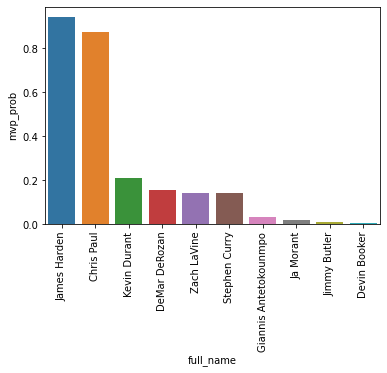

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
#mvp_candidates_names.plot.bar(x='full_name',y='mvp_prob' )
sns.barplot(x='full_name',y='mvp_prob',data=mvp_candidates_names.head(10))
plt.xticks(rotation=90)
#plt.savefig('plot/'+name_model+'_test30.png', bbox_inches='tight')

In [82]:
real_winners_2021 = ["NIKOLA JOKIC", "JOEL EMBIID", "STEPHEN CURRY", "GIANNIS ANTETOKOUNMPO", "CHRIS PAUL", "LUKA DONCIC", "DAMIAN LILLARD", "JULIUS RANDLE", "DERRICK ROSE", "RUDY GOBERT"]

real_winners_2021 = [str.title() for str in real_winners_2021] #Title for capitalize name and surname

versus = pd.DataFrame()
versus["Predicted_rank"] = list(mvp_candidates_names["full_name"].head(10))
versus["Real_rank"] = real_winners_2021
weight = list(reversed(range(1,11)))
i = 0
score = 0

# for row, names in versus.iterrows():
#     if names["Predicted_rank"] == names["Real_rank"]:
#         score = score + weight[i]
#     else:
#         j = i + 1
#         real_name = names["Real_rank"]
#         while names["Predicted_rank"] != real_name or j < 9:
#             real_name = versus.at[j,"Real_rank"]
#             j = j + 1
#
#         if j > 10:
#             score = score + weight[j]
#
#     i = i+1

for row, names in versus.iterrows():
    if names["Predicted_rank"] == names["Real_rank"]:
        score = score + weight[0]

score = score / sum(weight)
score



0.0